## Extracting SIFT points for all images

In [1]:
# loading the metadata
%load_ext autoreload
%autoreload 2

import pandas as pd
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn
import torchvision.models as models
from tqdm import tqdm
import torch
import pickle
from glob import glob
from scipy import sparse


from utils import *

path = '/home/guhennec/scratch/2021_Cini/TopologicalAnalysis_Cini/data/'
data_dir = '/scratch/students/schaerf/'

replica_dir = '/mnt/project_replica/datasets/cini/'


In [2]:
data = pd.read_csv(data_dir + 'dedup_data_sample.csv')
data.shape

(12862, 49)

86619


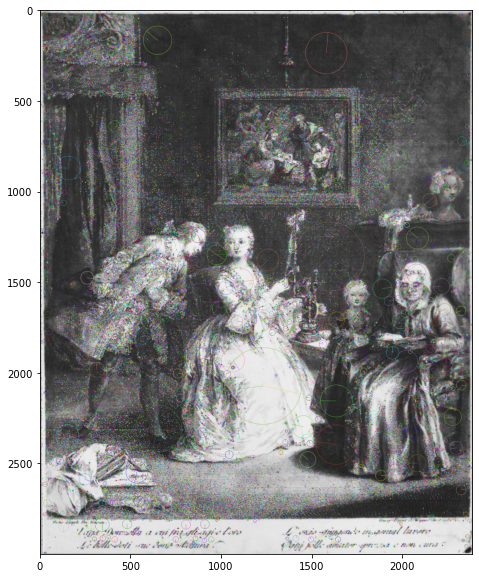

In [16]:
#reading image
img = cv2.imread(replica_dir + data.sample()['path'].values[0])  

#keypoints
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp = sift.detect(gray,None)
print(len(kp))
img=cv2.drawKeypoints(gray,kp,img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, ax = plt.subplots(1,1, figsize=(20,10))
plt.imshow(img)


In [15]:
train = pd.read_csv(data_dir + 'dataset/abc_train_100.csv')
train

,Unnamed: 0,index,A,B,C,set,A_path,B_path,C_path
0,0,5,06d37d5e06ce4b40b583c1cb6d7f68b2,b91c9e7b758249bfaa60046166560783,7af27cf8d2144f328e6fc5561c6ee213,train,157A/157A_49.jpg,158C/158C_213.jpg,156C/156C_231.jpg
1,1,5,06d37d5e06ce4b40b583c1cb6d7f68b2,b91c9e7b758249bfaa60046166560783,7918588e8a5e432b876915a0cd6894d7,train,157A/157A_49.jpg,158C/158C_213.jpg,71B/71B_43.jpg
2,2,5,06d37d5e06ce4b40b583c1cb6d7f68b2,b91c9e7b758249bfaa60046166560783,fe4fda9cacb94efe8da17aac33d8b6e4,train,157A/157A_49.jpg,158C/158C_213.jpg,121B/121B_575.jpg
3,3,5,06d37d5e06ce4b40b583c1cb6d7f68b2,b91c9e7b758249bfaa60046166560783,3879662544c94e91ad3b653cbe959db3,train,157A/157A_49.jpg,158C/158C_213.jpg,71B/71B_38.jpg
4,4,5,06d37d5e06ce4b40b583c1cb6d7f68b2,b91c9e7b758249bfaa60046166560783,30e42264670744019db1c1ba59ff3032,train,157A/157A_49.jpg,158C/158C_213.jpg,113C/113C_274.jpg
...,...,...,...,...,...,...,...,...,...
8761,8761,2858,a7d5691e942b4f439f4fbe15679a95a8,111f79c1ec1f4bfeb70b209d98204b4d,066c36f2a35f4ba583e7796a212203f1,train,53C/53C_256.jpg,47A/47A_824.jpg,57A/57A_868.jpg
8762,8762,2858,a7d5691e942b4f439f4fbe15679a95a8,111f79c1ec1f4bfeb70b209d98204b4d,5a46938b14bc41578444622568d16e5f,train,53C/53C_256.jpg,47A/47A_824.jpg,50C/50C_810.jpg
8763,8763,2858,a7d5691e942b4f439f4fbe15679a95a8,111f79c1ec1f4bfeb70b209d98204b4d,11e637725f7b448dae0e9b5759fa0850,train,53C/53C_256.jpg,47A/47A_824.jpg,97B/97B_537.jpg
8764,8764,2858,a7d5691e942b4f439f4fbe15679a95a8,111f79c1ec1f4bfeb70b209d98204b4d,addc1a1842f14f43b10dc2b5ef78aea3,train,53C/53C_256.jpg,47A/47A_824.jpg,160A/160A_451.jpg


600 370


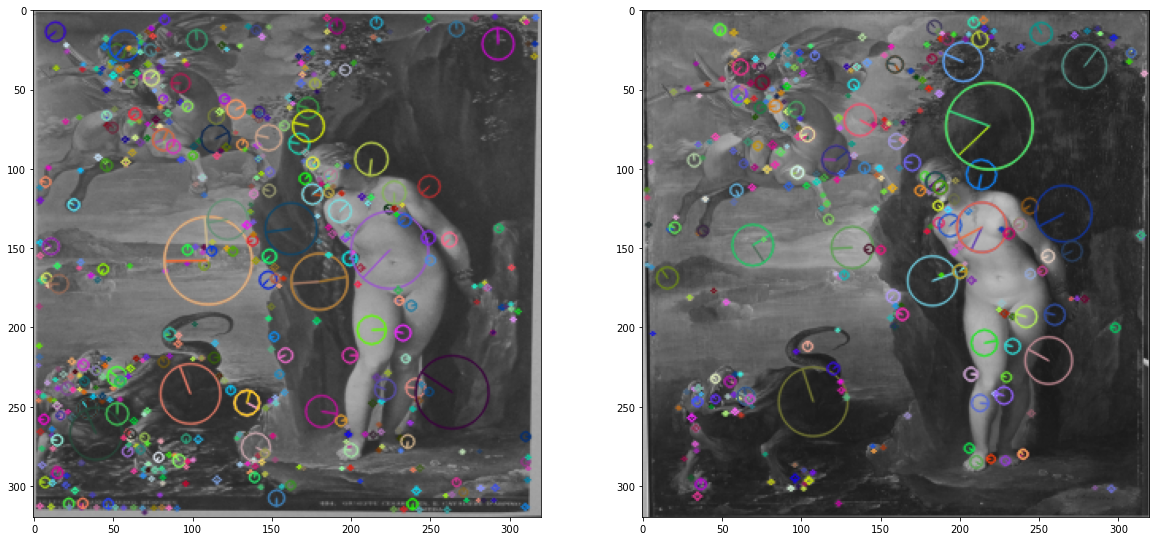

In [42]:
sample = train.sample()
img1 = cv2.imread(replica_dir + sample['A_path'].values[0]) 
img1 = cv2.resize(img1, (320,320), interpolation = cv2.INTER_AREA)
img2 = cv2.imread(replica_dir + sample['B_path'].values[0])  
img2 = cv2.resize(img2, (320,320), interpolation = cv2.INTER_AREA)

#keypoints
gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

kp1, des1 = sift.detectAndCompute(gray1,None)
kp2, des2 = sift.detectAndCompute(gray2,None)

print(len(kp1), len(kp2))

img1=cv2.drawKeypoints(gray1,kp1,img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2=cv2.drawKeypoints(gray2,kp2,img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].imshow(img1)
axs[1].imshow(img2)


191


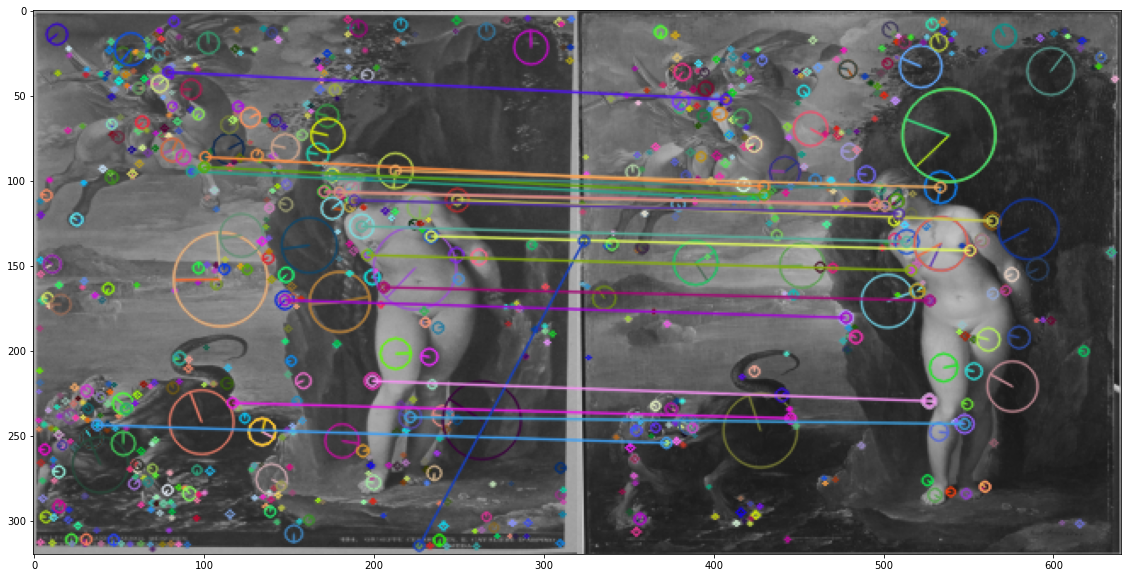

(<matplotlib.image.AxesImage at 0x7fa04fbde940>, None)

In [44]:
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

print(len(matches))
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], img2, flags=2, matchesThickness = 1)
fig, axs = plt.subplots(1,1, figsize=(20,10))
plt.imshow(img3),plt.show()

In [45]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

In [46]:
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)


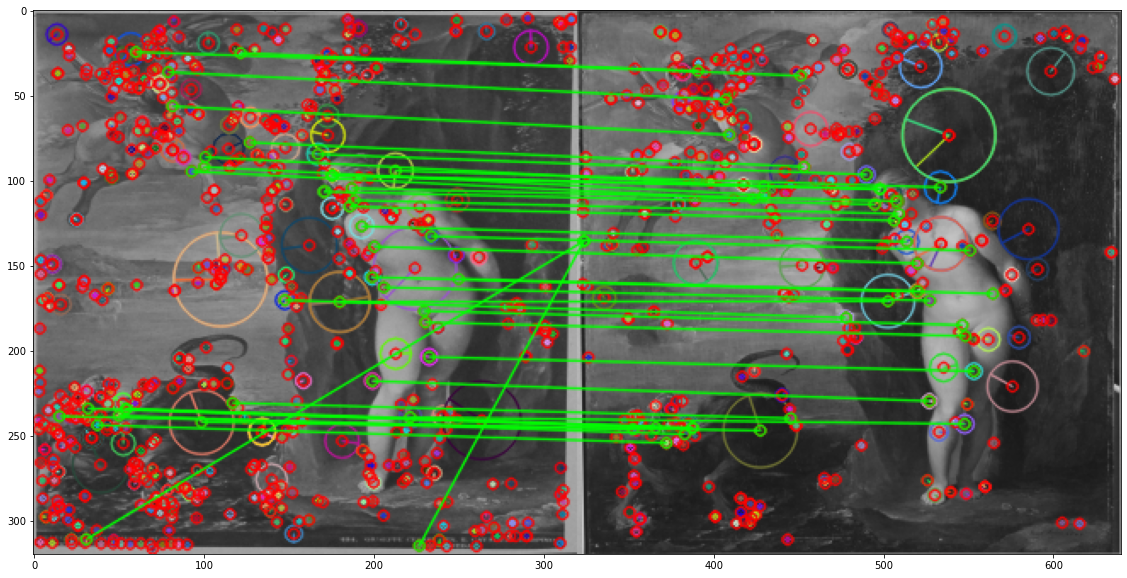

(<matplotlib.image.AxesImage at 0x7fa0502554c0>, None)

In [47]:

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.6*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   #matchesThickness = 3,
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
fig, axs = plt.subplots(1,1, figsize=(20,10))
plt.imshow(img3,),plt.show()